<a href="https://colab.research.google.com/github/brenoazvd/Pos_Tech_Machine_Learning/blob/main/previs%C3%A3o_novos_PETR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
dados = yf.download('PETR4.SA', start='2022-01-01')
precos = dados['Open'].dropna().values.reshape(-1, 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
base_treinamento = precos[:-30]
base_teste = precos[-30:]

In [5]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [6]:
previsores, preco_real = [], []
for i in range(90, len(base_treinamento_normalizada)):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])

previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [7]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(previsores.shape[1], 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=25, activation='relu'))
regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs=150, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
entrada_futura = precos[-90:].reshape(-1, 1)
entrada_futura_norm = normalizador.transform(entrada_futura)
sequencia = list(entrada_futura_norm.flatten())

previsoes_futuras = []
for _ in range(30):
    X_input = np.array(sequencia[-90:]).reshape(1, 90, 1)
    nova_previsao = regressor.predict(X_input, verbose=0)[0][0]
    previsoes_futuras.append(nova_previsao)
    sequencia.append(nova_previsao)

previsoes_futuras = np.array(previsoes_futuras).reshape(-1, 1)
previsoes_futuras_desnorm = normalizador.inverse_transform(previsoes_futuras)

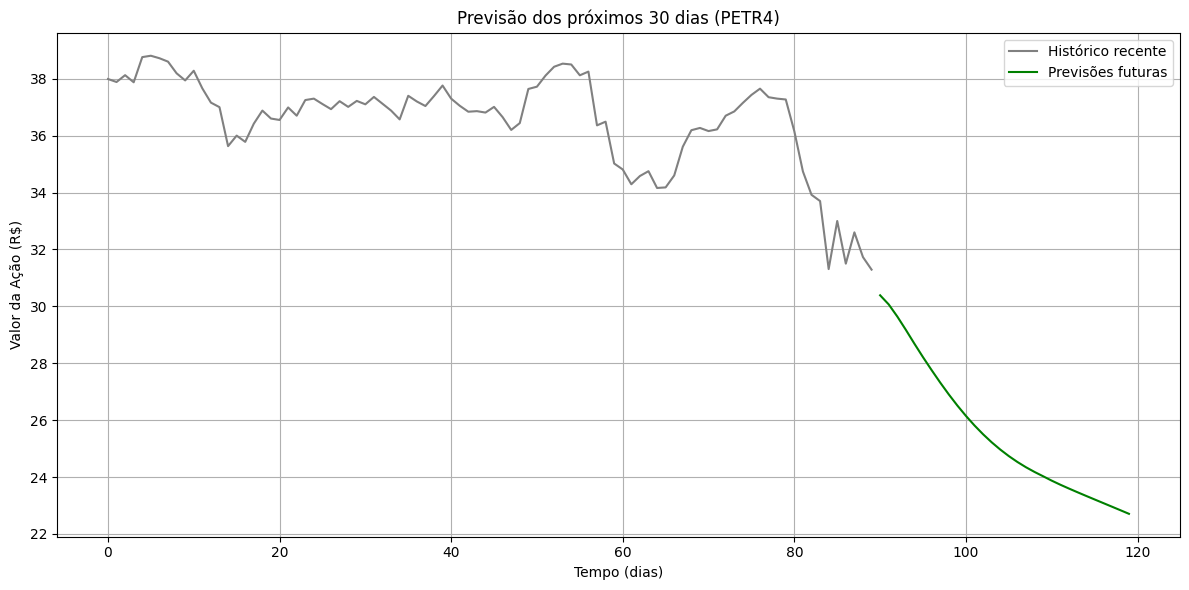

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(precos[-90:], color='gray', label='Histórico recente')
plt.plot(range(90, 120), previsoes_futuras_desnorm, color='green', label='Previsões futuras')
plt.title('Previsão dos próximos 30 dias (PETR4)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da Ação (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
previsoes = previsoes_futuras_desnorm[:len(base_teste)]
mae = mean_absolute_error(base_teste, previsoes)
rmse = mean_squared_error(base_teste, previsoes) ** 0.5

print(f"Média previsões: R${previsoes.mean():.2f}")
print(f"Média real: R${base_teste.mean():.2f}")
print(f"MAE: R${mae:.2f}")
print(f"RMSE: R${rmse:.2f}")

Média previsões: R$25.56
Média real: R$34.98
MAE: R$9.42
RMSE: R$9.80


In [16]:
# Recria os índices (datas) só com os dados que têm valor em 'Open'
datas_validas = dados['Open'].dropna().index

# Treino: do início até o -30º dia
datas_treino = datas_validas[:-30]

# Teste: os últimos 30 dias
datas_teste = datas_validas[-30:]

# Mostra os intervalos
print("🧪 Dados de TESTE:")
print("De:", datas_teste[0].date(), "até", datas_teste[-1].date())

print("\n📘 Dados de TREINO:")
print("De:", datas_treino[0].date(), "até", datas_treino[-1].date())

🧪 Dados de TESTE:
De: 2025-03-06 até 2025-04-16

📘 Dados de TREINO:
De: 2022-01-03 até 2025-03-05
